In [26]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/capstone/uli_dataset-main/LICENSE
/kaggle/input/capstone/uli_dataset-main/README.md
/kaggle/input/capstone/uli_dataset-main/training/train_en_l2.csv
/kaggle/input/capstone/uli_dataset-main/training/train_ta_l1.csv
/kaggle/input/capstone/uli_dataset-main/training/train_hi_l3.csv
/kaggle/input/capstone/uli_dataset-main/training/train_hi_l1.csv
/kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv
/kaggle/input/capstone/uli_dataset-main/training/train_hi_l2.csv
/kaggle/input/capstone/uli_dataset-main/training/train_ta_l2.csv
/kaggle/input/capstone/uli_dataset-main/training/train_ta_l3.csv
/kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv
/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l1.csv
/kaggle/input/capstone/uli_dataset-main/testing/test_ta_l2.csv
/kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv
/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l3.csv
/kaggle/input/capstone/uli_dataset-main/testing/test_hi_l2.csv
/k

In [1]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

# Create a custom transformer for sentence embeddings
class SentenceTransformerEmbedding(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return self.model.encode(X)
# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))



# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize, remove stopwords and lemmatize (optional - can be computational intensive)
    # Uncomment if you want this feature
    '''
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    '''
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text
class TextEmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

# BiLSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, dropout=0.2):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, 
                            bidirectional=True, dropout=dropout if n_layers > 1 else 0, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text shape: [batch size, embedding dim]
        # Reshaping to [batch size, 1, embedding dim] to simulate sequence length of 1
        text = text.unsqueeze(1)
        
        lstm_out, (hidden, cell) = self.lstm(text)
        
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        hidden = self.dropout(hidden)
        
        output = self.fc(hidden)
        return output

class PyTorchBiLSTMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=384, hidden_dim=128, dropout=0.2, n_layers=1, 
                 lr=0.001, epochs=10, batch_size=32, device=None):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.n_layers = n_layers
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.label_encoder = None
        self.classes_ = None
    
    def fit(self, X, y):
        # Encode labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        
        # Create dataset and loader
        dataset = TextEmbeddingDataset(X, y_encoded)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Initialize model
        self.output_dim = len(self.label_encoder.classes_)
        self.model = BiLSTMClassifier(
            input_dim=self.input_dim, 
            hidden_dim=self.hidden_dim,
            output_dim=self.output_dim,
            n_layers=self.n_layers,
            dropout=self.dropout
        ).to(self.device)
        
        # Define optimizer and loss
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {total_loss/len(train_loader):.4f}')
        
        return self
    
    def predict(self, X):
        self.model.eval()
        predictions = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
        
        return self.label_encoder.inverse_transform(predictions)
    
    def predict_proba(self, X):
        self.model.eval()
        probabilities = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                probabilities.extend(probs.cpu().numpy())
        
        return np.array(probabilities)

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_english_classifier(train_file, test_file=None):
    """
    Train an English text classifier using bilstm and evaluate on test data.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution.png')
        print("Class distribution plot saved as 'training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        # Create a pipeline with TF-IDF and bilstm - optimized for English
        
        # Create a pipeline with Sentence Transformer embeddings and BiLSTM
        print("\nCreating and training the BiLSTM model...")
        pipeline = Pipeline([
            ('embeddings', SentenceTransformerEmbedding()),
            ('classifier', PyTorchBiLSTMWrapper(
                input_dim=384,  # Default dimension for all-MiniLM-L6-v2
                hidden_dim=128,
                dropout=0.3,
                n_layers=2,
                lr=0.001,
                epochs=80,
                batch_size=32
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("bilstm model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence (probability of the predicted class)
        confidence_values = []
        for i, pred_class in enumerate(predictions_class):
            class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
            confidence_values.append(prediction_probs[i][class_index])
        
        df['prediction_confidence'] = confidence_values
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='english_bilstm_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='english_bilstm_classifier_model.pkl', 
                          test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_english_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Get prediction probabilities
            prediction_probs = model.predict_proba(df['processed_text'])
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Add prediction confidence
            confidence_values = []
            for i, pred_class in enumerate(predictions_class):
                class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
                confidence_values.append(prediction_probs[i][class_index])
            
            df['prediction_confidence'] = confidence_values
            
            # Save results
            output_file = "bilstm_predictions_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample text...")
            processed_text = preprocess_english_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            # Get prediction probability
            prediction_prob = model.predict_proba([processed_text])[0]
            class_index = list(model.named_steps['classifier'].classes_).index(prediction_class)
            confidence = prediction_prob[class_index]
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            print(f"Confidence: {confidence:.4f}")
            
            return prediction_class, prediction_value, confidence
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None



2025-04-14 13:52:59.097724: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1744638779.317480      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1744638779.378429      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: cuda
Training BiLSTM model on /kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv...
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    5269
1.0    1262
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution.png'

Creating and training the BiLSTM model...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 1/80, Loss: 0.4367
Epoch 2/80, Loss: 0.3810
Epoch 3/80, Loss: 0.3714
Epoch 4/80, Loss: 0.3664
Epoch 5/80, Loss: 0.3648
Epoch 6/80, Loss: 0.3591
Epoch 7/80, Loss: 0.3571
Epoch 8/80, Loss: 0.3535
Epoch 9/80, Loss: 0.3518
Epoch 10/80, Loss: 0.3477
Epoch 11/80, Loss: 0.3401
Epoch 12/80, Loss: 0.3356
Epoch 13/80, Loss: 0.3257
Epoch 14/80, Loss: 0.3225
Epoch 15/80, Loss: 0.3120
Epoch 16/80, Loss: 0.3007
Epoch 17/80, Loss: 0.2890
Epoch 18/80, Loss: 0.2757
Epoch 19/80, Loss: 0.2632
Epoch 20/80, Loss: 0.2503
Epoch 21/80, Loss: 0.2380
Epoch 22/80, Loss: 0.2201
Epoch 23/80, Loss: 0.1991
Epoch 24/80, Loss: 0.1868
Epoch 25/80, Loss: 0.1668
Epoch 26/80, Loss: 0.1486
Epoch 27/80, Loss: 0.1385
Epoch 28/80, Loss: 0.1264
Epoch 29/80, Loss: 0.1133
Epoch 30/80, Loss: 0.1009
Epoch 31/80, Loss: 0.0826
Epoch 32/80, Loss: 0.0847
Epoch 33/80, Loss: 0.0743
Epoch 34/80, Loss: 0.0610
Epoch 35/80, Loss: 0.0692
Epoch 36/80, Loss: 0.0594
Epoch 37/80, Loss: 0.0553
Epoch 38/80, Loss: 0.0453
Epoch 39/80, Loss: 0.

Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6485

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       877
         1.0       0.49      0.38      0.43       230

    accuracy                           0.79      1107
   macro avg       0.67      0.64      0.65      1107
weighted avg       0.77      0.79      0.78      1107

Confusion matrix saved as 'confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'test_predictions.csv'
Saving model to english_bilstm_classifier_st_l1.pkl...
Model saved successfully to english_bilstm_classifier_st_l1.pkl
Model saved. Macro F1 score: 0.6485

Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      0.90      0.87       877
         1.0       0.49      0.38      0.43       230

    accuracy                           0.79      1107
   macro avg       0.67      0.64      0.65      1107
weig

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: This is a test message to check if the BiLSTM model works correctly.
Processed text: this is a test message to check if the bilstm model works correctly
Prediction (class): 0.0
Prediction (value): 0.0
Confidence: 1.0000

Sample text: 'This is a test message to check if the BiLSTM model works correctly.'
Prediction class: 0.0
Prediction value: 0.0
Confidence: 1.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


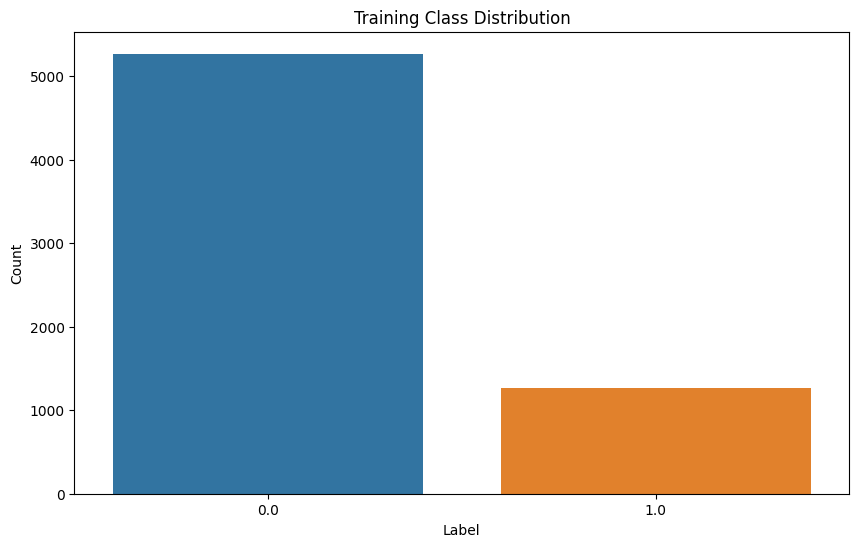

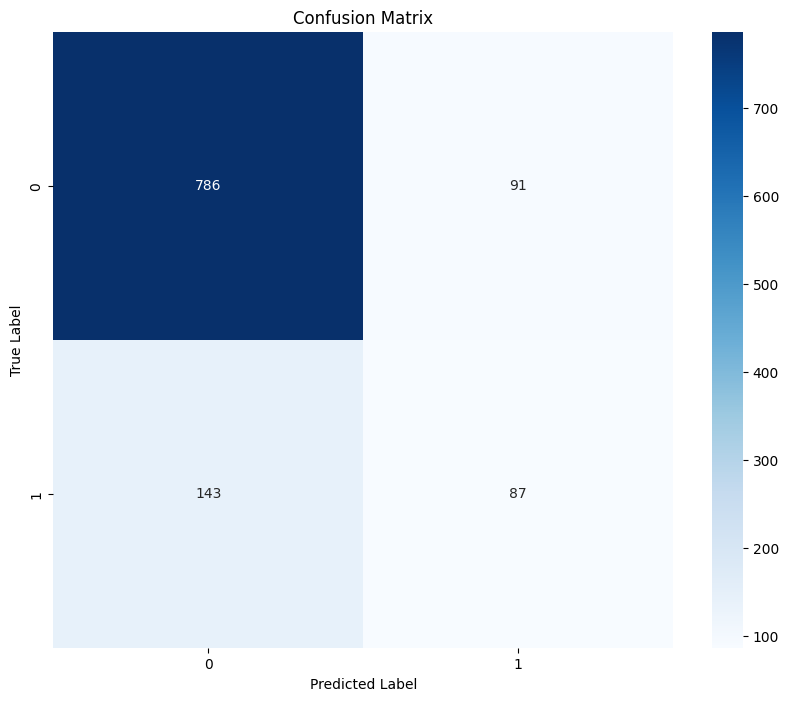

In [2]:
# Example usage
if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Path to dataset files
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv"
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv"
    
    # Example 1: Train and save model
    print(f"Training BiLSTM model on {train_file}...")
    model, f1, report = train_english_classifier(train_file, test_file)
    
    if model:
        # Save the model
        save_model(model, "english_bilstm_classifier_st_l1.pkl")
        print(f"Model saved. Macro F1 score: {f1:.4f}")
        print("\nClassification Report:")
        print(report)
    
    # Example 2: Load model and predict on sample text
    print("\nTesting model on sample text...")
    sample_text = "This is a test message to check if the BiLSTM model works correctly."
    
    prediction_class, prediction_value, confidence = load_model_and_predict(
        "english_bilstm_classifier_st_l1.pkl", 
        sample_text=sample_text
    )
    
    print(f"\nSample text: '{sample_text}'")
    print(f"Prediction class: {prediction_class}")
    print(f"Prediction value: {prediction_value}")
    print(f"Confidence: {confidence:.4f}")
    
    # Optional: Test on new data file
    new_data_file = "/kaggle/input/capstone/uli_dataset-main/new_data.csv"
    if os.path.exists(new_data_file):
        print(f"\nPredicting on new data file: {new_data_file}")
        results_df = predict_on_new_data(
            model, 
            new_data_file, 
            "bilstm_predictions.csv"
        )
        print("Prediction complete!")

In [3]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

# Create a custom transformer for sentence embeddings
class SentenceTransformerEmbedding(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return self.model.encode(X)
# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))



# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize, remove stopwords and lemmatize (optional - can be computational intensive)
    # Uncomment if you want this feature
    '''
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    '''
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text
class TextEmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

# BiLSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, dropout=0.2):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, 
                            bidirectional=True, dropout=dropout if n_layers > 1 else 0, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text shape: [batch size, embedding dim]
        # Reshaping to [batch size, 1, embedding dim] to simulate sequence length of 1
        text = text.unsqueeze(1)
        
        lstm_out, (hidden, cell) = self.lstm(text)
        
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        hidden = self.dropout(hidden)
        
        output = self.fc(hidden)
        return output

class PyTorchBiLSTMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=384, hidden_dim=128, dropout=0.2, n_layers=1, 
                 lr=0.001, epochs=10, batch_size=32, device=None):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.n_layers = n_layers
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.label_encoder = None
        self.classes_ = None
    
    def fit(self, X, y):
        # Encode labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        
        # Create dataset and loader
        dataset = TextEmbeddingDataset(X, y_encoded)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Initialize model
        self.output_dim = len(self.label_encoder.classes_)
        self.model = BiLSTMClassifier(
            input_dim=self.input_dim, 
            hidden_dim=self.hidden_dim,
            output_dim=self.output_dim,
            n_layers=self.n_layers,
            dropout=self.dropout
        ).to(self.device)
        
        # Define optimizer and loss
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {total_loss/len(train_loader):.4f}')
        
        return self
    
    def predict(self, X):
        self.model.eval()
        predictions = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
        
        return self.label_encoder.inverse_transform(predictions)
    
    def predict_proba(self, X):
        self.model.eval()
        probabilities = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                probabilities.extend(probs.cpu().numpy())
        
        return np.array(probabilities)

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_english_classifier(train_file, test_file=None):
    """
    
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution.png')
        print("Class distribution plot saved as 'training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        
        
        # Create a pipeline with Sentence Transformer embeddings and BiLSTM
        print("\nCreating and training the BiLSTM model...")
        pipeline = Pipeline([
            ('embeddings', SentenceTransformerEmbedding()),
            ('classifier', PyTorchBiLSTMWrapper(
                input_dim=384,  # Default dimension for all-MiniLM-L6-v2
                hidden_dim=128,
                dropout=0.3,
                n_layers=2,
                lr=0.001,
                epochs=80,
                batch_size=32
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("bilstm model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence (probability of the predicted class)
        confidence_values = []
        for i, pred_class in enumerate(predictions_class):
            class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
            confidence_values.append(prediction_probs[i][class_index])
        
        df['prediction_confidence'] = confidence_values
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='english_bilstm_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='english_bilstm_classifier_model.pkl', 
                          test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_english_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Get prediction probabilities
            prediction_probs = model.predict_proba(df['processed_text'])
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Add prediction confidence
            confidence_values = []
            for i, pred_class in enumerate(predictions_class):
                class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
                confidence_values.append(prediction_probs[i][class_index])
            
            df['prediction_confidence'] = confidence_values
            
            # Save results
            output_file = "bilstm_predictions_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample text...")
            processed_text = preprocess_english_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            # Get prediction probability
            prediction_prob = model.predict_proba([processed_text])[0]
            class_index = list(model.named_steps['classifier'].classes_).index(prediction_class)
            confidence = prediction_prob[class_index]
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            print(f"Confidence: {confidence:.4f}")
            
            return prediction_class, prediction_value, confidence
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: cuda
Training BiLSTM model on /kaggle/input/capstone/uli_dataset-main/training/train_en_l2.csv...
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l2.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    4538
1.0    1993
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution.png'

Creating and training the BiLSTM model...


Batches:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 1/80, Loss: 0.5726
Epoch 2/80, Loss: 0.5278
Epoch 3/80, Loss: 0.5251
Epoch 4/80, Loss: 0.5201
Epoch 5/80, Loss: 0.5161
Epoch 6/80, Loss: 0.5092
Epoch 7/80, Loss: 0.5093
Epoch 8/80, Loss: 0.5020
Epoch 9/80, Loss: 0.5015
Epoch 10/80, Loss: 0.4958
Epoch 11/80, Loss: 0.4863
Epoch 12/80, Loss: 0.4808
Epoch 13/80, Loss: 0.4758
Epoch 14/80, Loss: 0.4642
Epoch 15/80, Loss: 0.4544
Epoch 16/80, Loss: 0.4446
Epoch 17/80, Loss: 0.4305
Epoch 18/80, Loss: 0.4193
Epoch 19/80, Loss: 0.3986
Epoch 20/80, Loss: 0.3864
Epoch 21/80, Loss: 0.3598
Epoch 22/80, Loss: 0.3379
Epoch 23/80, Loss: 0.3146
Epoch 24/80, Loss: 0.2917
Epoch 25/80, Loss: 0.2723
Epoch 26/80, Loss: 0.2575
Epoch 27/80, Loss: 0.2274
Epoch 28/80, Loss: 0.2082
Epoch 29/80, Loss: 0.1927
Epoch 30/80, Loss: 0.1762
Epoch 31/80, Loss: 0.1617
Epoch 32/80, Loss: 0.1438
Epoch 33/80, Loss: 0.1337
Epoch 34/80, Loss: 0.1207
Epoch 35/80, Loss: 0.1129
Epoch 36/80, Loss: 0.1018
Epoch 37/80, Loss: 0.0944
Epoch 38/80, Loss: 0.0845
Epoch 39/80, Loss: 0.

Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6343

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78       716
         1.0       0.58      0.43      0.49       391

    accuracy                           0.69      1107
   macro avg       0.65      0.63      0.63      1107
weighted avg       0.68      0.69      0.68      1107

Confusion matrix saved as 'confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'test_predictions.csv'
Saving model to english_bilstm_classifier_st_l2.pkl...
Model saved successfully to english_bilstm_classifier_st_l2.pkl
Model saved. Macro F1 score: 0.6343

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.83      0.78       716
         1.0       0.58      0.43      0.49       391

    accuracy                           0.69      1107
   macro avg       0.65      0.63      0.63      1107
weig

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: This is a test message to check if the BiLSTM model works correctly.
Processed text: this is a test message to check if the bilstm model works correctly
Prediction (class): 0.0
Prediction (value): 0.0
Confidence: 1.0000

Sample text: 'This is a test message to check if the BiLSTM model works correctly.'
Prediction class: 0.0
Prediction value: 0.0
Confidence: 1.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


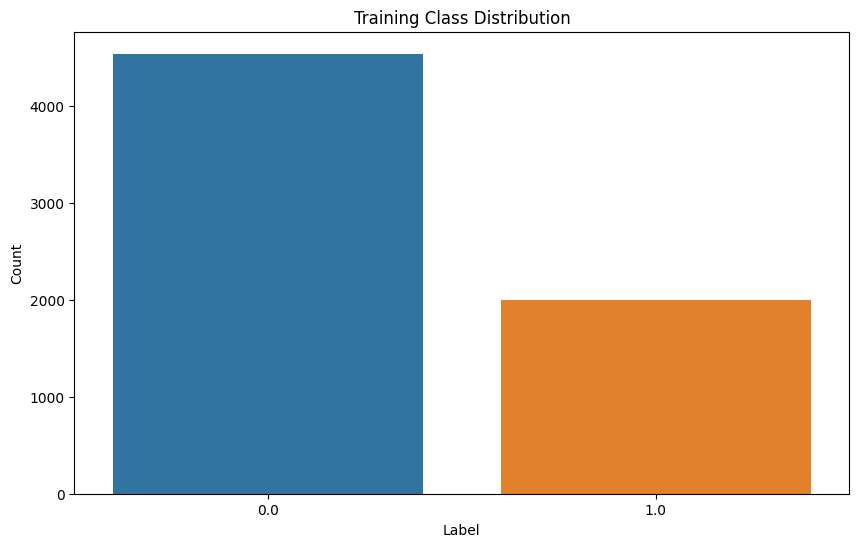

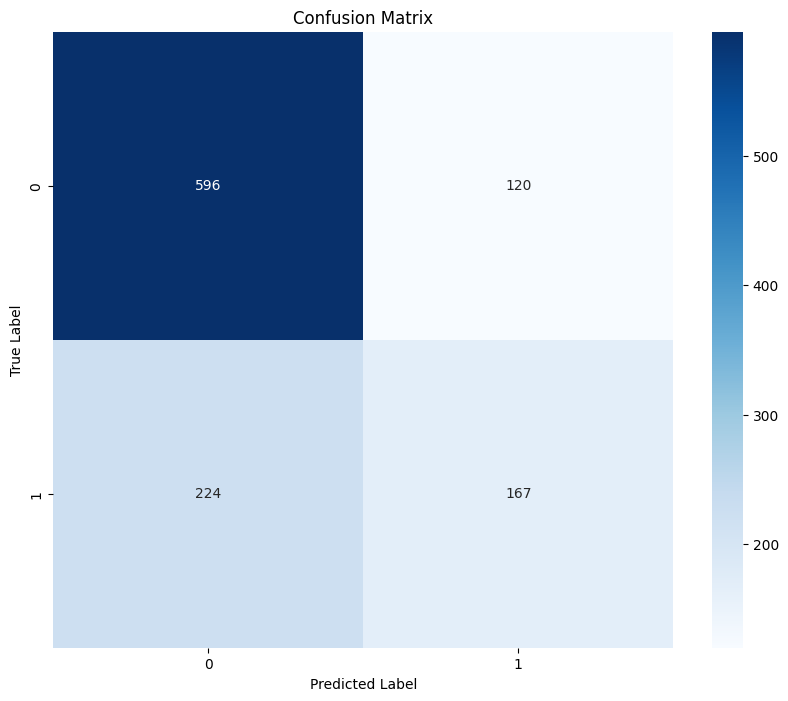

In [5]:

if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Path to dataset files
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l2.csv"
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l2.csv"
    
    # Example 1: Train and save model
    print(f"Training BiLSTM model on {train_file}...")
    model, f1, report = train_english_classifier(train_file, test_file)
    
    if model:
        # Save the model
        save_model(model, "english_bilstm_classifier_st_l2.pkl")
        print(f"Model saved. Macro F1 score: {f1:.4f}")
        print("\nClassification Report:")
        print(report)
    
    # Example 2: Load model and predict on sample text
    print("\nTesting model on sample text...")
    sample_text = "This is a test message to check if the BiLSTM model works correctly."
    
    prediction_class, prediction_value, confidence = load_model_and_predict(
        "english_bilstm_classifier_st_l2.pkl", 
        sample_text=sample_text
    )
    
    print(f"\nSample text: '{sample_text}'")
    print(f"Prediction class: {prediction_class}")
    print(f"Prediction value: {prediction_value}")
    print(f"Confidence: {confidence:.4f}")
    
    # Optional: Test on new data file
    new_data_file = "/kaggle/input/capstone/uli_dataset-main/new_data.csv"
    if os.path.exists(new_data_file):
        print(f"\nPredicting on new data file: {new_data_file}")
        results_df = predict_on_new_data(
            model, 
            new_data_file, 
            "bilstm_predictions.csv"
        )
        print("Prediction complete!")

In [7]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
import numpy as np
from sklearn.base import BaseEstimator, ClassifierMixin

# Create a custom transformer for sentence embeddings
class SentenceTransformerEmbedding(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        return self.model.encode(X)
# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))



# Function to preprocess English text
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Tokenize, remove stopwords and lemmatize (optional - can be computational intensive)
    # Uncomment if you want this feature
    '''
    tokens = nltk.word_tokenize(text)
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    text = ' '.join(tokens)
    '''
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text
class TextEmbeddingDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = embeddings
        self.labels = labels
        
    def __len__(self):
        return len(self.embeddings)
    
    def __getitem__(self, idx):
        return torch.tensor(self.embeddings[idx], dtype=torch.float), torch.tensor(self.labels[idx], dtype=torch.long)

# BiLSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, n_layers=1, dropout=0.2):
        super(BiLSTMClassifier, self).__init__()
        self.hidden_dim = hidden_dim
        self.n_layers = n_layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, n_layers, 
                            bidirectional=True, dropout=dropout if n_layers > 1 else 0, 
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim * 2, output_dim)  # *2 for bidirectional
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, text):
        # text shape: [batch size, embedding dim]
        # Reshaping to [batch size, 1, embedding dim] to simulate sequence length of 1
        text = text.unsqueeze(1)
        
        lstm_out, (hidden, cell) = self.lstm(text)
        
        # Concatenate the final forward and backward hidden states
        hidden = torch.cat([hidden[-2], hidden[-1]], dim=1)
        hidden = self.dropout(hidden)
        
        output = self.fc(hidden)
        return output

class PyTorchBiLSTMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, input_dim=384, hidden_dim=128, dropout=0.2, n_layers=1, 
                 lr=0.001, epochs=10, batch_size=32, device=None):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.dropout = dropout
        self.n_layers = n_layers
        self.lr = lr
        self.epochs = epochs
        self.batch_size = batch_size
        self.device = device if device else ('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = None
        self.label_encoder = None
        self.classes_ = None
    
    def fit(self, X, y):
        # Encode labels
        self.label_encoder = LabelEncoder()
        y_encoded = self.label_encoder.fit_transform(y)
        self.classes_ = self.label_encoder.classes_
        
        # Create dataset and loader
        dataset = TextEmbeddingDataset(X, y_encoded)
        train_loader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Initialize model
        self.output_dim = len(self.label_encoder.classes_)
        self.model = BiLSTMClassifier(
            input_dim=self.input_dim, 
            hidden_dim=self.hidden_dim,
            output_dim=self.output_dim,
            n_layers=self.n_layers,
            dropout=self.dropout
        ).to(self.device)
        
        # Define optimizer and loss
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        criterion = nn.CrossEntropyLoss()
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            print(f'Epoch {epoch+1}/{self.epochs}, Loss: {total_loss/len(train_loader):.4f}')
        
        return self
    
    def predict(self, X):
        self.model.eval()
        predictions = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                _, preds = torch.max(outputs, 1)
                predictions.extend(preds.cpu().numpy())
        
        return self.label_encoder.inverse_transform(predictions)
    
    def predict_proba(self, X):
        self.model.eval()
        probabilities = []
        
        # Create dataset and loader for predictions
        dummy_y = np.zeros(len(X))
        dataset = TextEmbeddingDataset(X, dummy_y)
        data_loader = DataLoader(dataset, batch_size=self.batch_size)
        
        with torch.no_grad():
            for inputs, _ in data_loader:
                inputs = inputs.to(self.device)
                outputs = self.model(inputs)
                probs = torch.softmax(outputs, dim=1)
                probabilities.extend(probs.cpu().numpy())
        
        return np.array(probabilities)

# Function to calculate majority vote
def majority_vote(row):
    # Extract annotation columns - adjust these column names for your English dataset
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5','en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_english_classifier(train_file, test_file=None):
    """
    Train an English text classifier using bilstm and evaluate on test data.
    
    Args:
        train_file: Path to the training CSV file
        test_file: Path to the test CSV file (optional)
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the training CSV file
        print(f"Reading training data from {train_file}...")
        train_df = pd.read_csv(train_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing training text...")
        train_df['processed_text'] = train_df['text'].apply(preprocess_english_text)
        
        # Calculate majority vote for labels in training data
        print("Calculating majority vote for training labels...")
        train_df['final_label'] = train_df.apply(majority_vote, axis=1)
        
        # Convert floating point labels to string classes to ensure categorical treatment
        train_df['label_class'] = train_df['final_label'].astype(str)
        
        # Print the class distribution
        print("\nTraining class distribution:")
        class_dist = train_df['label_class'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='label_class', data=train_df)
        plt.title('Training Class Distribution')
        plt.xlabel('Label')
        plt.ylabel('Count')
        plt.savefig('training_class_distribution.png')
        print("Class distribution plot saved as 'training_class_distribution.png'")
        
        # Prepare training data
        X_train = train_df['processed_text']
        y_train = train_df['label_class']  # Using string class labels
        
        
        
        # Create a pipeline with Sentence Transformer embeddings and BiLSTM
        print("\nCreating and training the BiLSTM model...")
        pipeline = Pipeline([
            ('embeddings', SentenceTransformerEmbedding()),
            ('classifier', PyTorchBiLSTMWrapper(
                input_dim=384,  # Default dimension for all-MiniLM-L6-v2
                hidden_dim=128,
                dropout=0.3,
                n_layers=2,
                lr=0.001,
                epochs=80,
                batch_size=32
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("bilstm model training complete!")
        
        # If test file is provided, evaluate on it
        if test_file:
            print(f"\nReading test data from {test_file}...")
            test_df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess test text
            print("Preprocessing test text...")
            test_df['processed_text'] = test_df['text'].apply(preprocess_english_text)
            
            # Calculate majority vote for labels in test data
            print("Calculating majority vote for test labels...")
            test_df['final_label'] = test_df.apply(majority_vote, axis=1)
            
            # Convert to string classes to match training data
            test_df['label_class'] = test_df['final_label'].astype(str)
            
            # Prepare test data
            X_test = test_df['processed_text']
            y_test = test_df['label_class']
            
            # Make predictions
            print("Making predictions on test data...")
            y_pred = pipeline.predict(X_test)
            
            # Calculate metrics
            print("\nEvaluating model performance...")
            macro_f1 = f1_score(y_test, y_pred, average='macro')
            
            print(f"\nMacro F1 Score: {macro_f1:.4f}")
            print("\nDetailed Classification Report:")
            report = classification_report(y_test, y_pred)
            print(report)
            
            # Create confusion matrix
            cm = confusion_matrix(y_test, y_pred)
            plt.figure(figsize=(10, 8))
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
            plt.title('Confusion Matrix')
            plt.xlabel('Predicted Label')
            plt.ylabel('True Label')
            plt.savefig('confusion_matrix.png')
            print("Confusion matrix saved as 'confusion_matrix.png'")
            
            # Save sample predictions with both string and original numeric labels
            print("\nSaving sample predictions...")
            results_df = pd.DataFrame({
                'text': X_test.values,
                'true_label_class': y_test.values,
                'true_label_value': test_df['final_label'].values,
                'predicted_label_class': y_pred,
                'predicted_label_value': [float(label) for label in y_pred]  # Convert back to float for reporting
            })
            results_df.to_csv('test_predictions.csv', index=False)
            print("Test predictions saved to 'test_predictions.csv'")
            
            return pipeline, macro_f1, report
        
        else:
            print("\nNo test file provided. Model trained successfully.")
            return pipeline, None, None
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

def predict_on_new_data(model, input_file, output_file):
    """
    Use a trained model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions_class = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Convert string predictions back to float values for consistency
        predictions_value = [float(pred) for pred in predictions_class]
        
        # Add predictions to dataframe
        df['predicted_label_class'] = predictions_class
        df['predicted_label_value'] = predictions_value
        
        # Add prediction confidence (probability of the predicted class)
        confidence_values = []
        for i, pred_class in enumerate(predictions_class):
            class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
            confidence_values.append(prediction_probs[i][class_index])
        
        df['prediction_confidence'] = confidence_values
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions_class).value_counts()
        print(pred_dist)
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def save_model(model, model_path='english_bilstm_classifier_model.pkl'):
    """
    Save the trained model to a file
    
    Args:
        model: Trained classifier pipeline
        model_path: Path where to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        joblib.dump(model, model_path)
        print(f"Model saved successfully to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        return False

def load_model_and_predict(model_path='english_bilstm_classifier_model.pkl', 
                          test_file=None, sample_text=None):
    """
    Load a trained model and use it for inference on a test file or sample text
    
    Args:
        model_path: Path to the saved model file
        test_file: Path to a CSV file containing texts to predict
        sample_text: A single text string to predict
        
    Returns:
        Predictions or a single prediction
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        model = joblib.load(model_path)
        print("Model loaded successfully!")
        
        if test_file and os.path.exists(test_file):
            # Predict on test file
            print(f"Predicting on test file: {test_file}")
            df = pd.read_csv(test_file, quoting=csv.QUOTE_MINIMAL)
            
            # Preprocess text
            df['processed_text'] = df['text'].apply(preprocess_english_text)
            
            # Make predictions
            predictions_class = model.predict(df['processed_text'])
            predictions_value = [float(pred) for pred in predictions_class]
            
            # Get prediction probabilities
            prediction_probs = model.predict_proba(df['processed_text'])
            
            # Add predictions to dataframe
            df['predicted_label_class'] = predictions_class
            df['predicted_label_value'] = predictions_value
            
            # Add prediction confidence
            confidence_values = []
            for i, pred_class in enumerate(predictions_class):
                class_index = list(model.named_steps['classifier'].classes_).index(pred_class)
                confidence_values.append(prediction_probs[i][class_index])
            
            df['prediction_confidence'] = confidence_values
            
            # Save results
            output_file = "bilstm_predictions_output.csv"
            df.to_csv(output_file, index=False)
            print(f"Predictions saved to {output_file}")
            
            return df
            
        elif sample_text:
            # Predict on a single text
            print("Predicting on sample text...")
            processed_text = preprocess_english_text(sample_text)
            prediction_class = model.predict([processed_text])[0]
            prediction_value = float(prediction_class)
            
            # Get prediction probability
            prediction_prob = model.predict_proba([processed_text])[0]
            class_index = list(model.named_steps['classifier'].classes_).index(prediction_class)
            confidence = prediction_prob[class_index]
            
            print(f"Text: {sample_text}")
            print(f"Processed text: {processed_text}")
            print(f"Prediction (class): {prediction_class}")
            print(f"Prediction (value): {prediction_value}")
            print(f"Confidence: {confidence:.4f}")
            
            return prediction_class, prediction_value, confidence
        
        else:
            print("Error: Please provide either a test file or sample text.")
            return None
            
    except Exception as e:
        print(f"Error during inference: {e}")
        import traceback
        traceback.print_exc()
        return None


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Using device: cuda
Training BiLSTM model on /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv...
Reading training data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv...
Preprocessing training text...
Calculating majority vote for training labels...

Training class distribution:
label_class
0.0    4309
1.0    2222
Name: count, dtype: int64
Class distribution plot saved as 'training_class_distribution.png'

Creating and training the BiLSTM model...


Batches:   0%|          | 0/205 [00:00<?, ?it/s]

Epoch 1/80, Loss: 0.5953
Epoch 2/80, Loss: 0.5579
Epoch 3/80, Loss: 0.5515
Epoch 4/80, Loss: 0.5442
Epoch 5/80, Loss: 0.5381
Epoch 6/80, Loss: 0.5380
Epoch 7/80, Loss: 0.5292
Epoch 8/80, Loss: 0.5266
Epoch 9/80, Loss: 0.5192
Epoch 10/80, Loss: 0.5105
Epoch 11/80, Loss: 0.5025
Epoch 12/80, Loss: 0.4968
Epoch 13/80, Loss: 0.4831
Epoch 14/80, Loss: 0.4730
Epoch 15/80, Loss: 0.4677
Epoch 16/80, Loss: 0.4539
Epoch 17/80, Loss: 0.4440
Epoch 18/80, Loss: 0.4215
Epoch 19/80, Loss: 0.4057
Epoch 20/80, Loss: 0.3881
Epoch 21/80, Loss: 0.3691
Epoch 22/80, Loss: 0.3469
Epoch 23/80, Loss: 0.3218
Epoch 24/80, Loss: 0.3020
Epoch 25/80, Loss: 0.2793
Epoch 26/80, Loss: 0.2595
Epoch 27/80, Loss: 0.2382
Epoch 28/80, Loss: 0.2178
Epoch 29/80, Loss: 0.1899
Epoch 30/80, Loss: 0.1720
Epoch 31/80, Loss: 0.1570
Epoch 32/80, Loss: 0.1514
Epoch 33/80, Loss: 0.1491
Epoch 34/80, Loss: 0.1258
Epoch 35/80, Loss: 0.1070
Epoch 36/80, Loss: 0.1002
Epoch 37/80, Loss: 0.0950
Epoch 38/80, Loss: 0.0887
Epoch 39/80, Loss: 0.

Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6544

Detailed Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.82      0.77       699
         1.0       0.61      0.48      0.54       408

    accuracy                           0.70      1107
   macro avg       0.67      0.65      0.65      1107
weighted avg       0.69      0.70      0.69      1107

Confusion matrix saved as 'confusion_matrix.png'

Saving sample predictions...
Test predictions saved to 'test_predictions.csv'
Saving model to english_bilstm_classifier_st_l3.pkl...
Model saved successfully to english_bilstm_classifier_st_l3.pkl
Model saved. Macro F1 score: 0.6544

Classification Report:
              precision    recall  f1-score   support

         0.0       0.73      0.82      0.77       699
         1.0       0.61      0.48      0.54       408

    accuracy                           0.70      1107
   macro avg       0.67      0.65      0.65      1107
weig

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Text: This is a test message to check if the BiLSTM model works correctly.
Processed text: this is a test message to check if the bilstm model works correctly
Prediction (class): 1.0
Prediction (value): 1.0
Confidence: 1.0000

Sample text: 'This is a test message to check if the BiLSTM model works correctly.'
Prediction class: 1.0
Prediction value: 1.0
Confidence: 1.0000


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


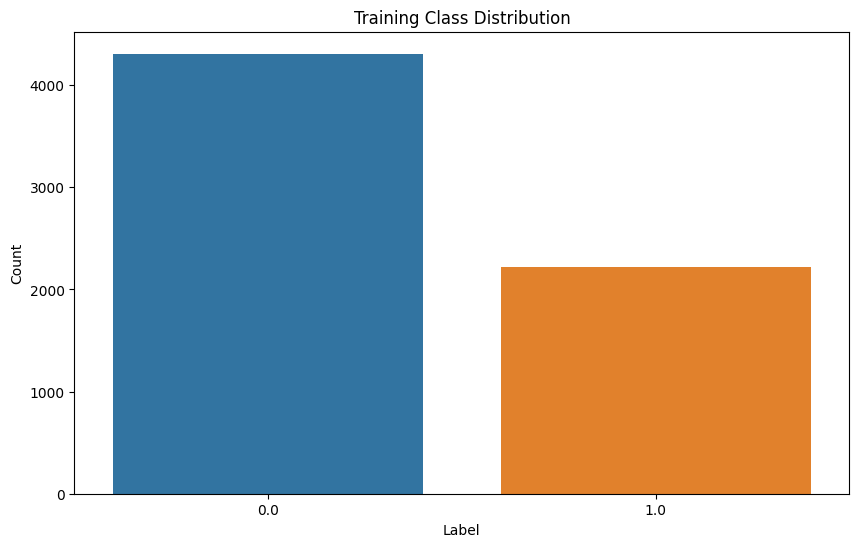

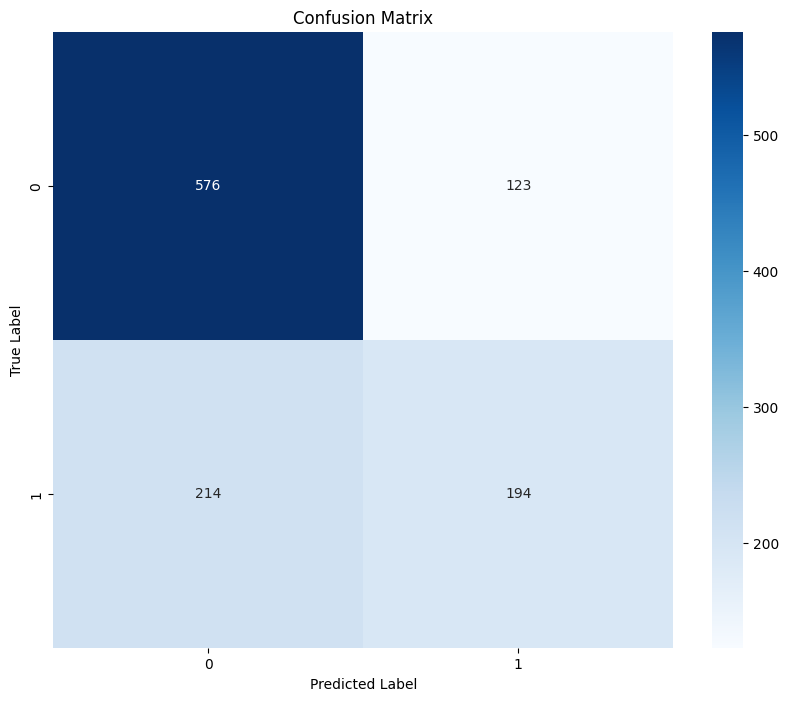

In [8]:

if __name__ == "__main__":
    # Set device
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    print(f"Using device: {device}")
    
    # Path to dataset files
    train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv"
    test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv"
    
    # Example 1: Train and save model
    print(f"Training BiLSTM model on {train_file}...")
    model, f1, report = train_english_classifier(train_file, test_file)
    
    if model:
        # Save the model
        save_model(model, "english_bilstm_classifier_st_l3.pkl")
        print(f"Model saved. Macro F1 score: {f1:.4f}")
        print("\nClassification Report:")
        print(report)
    
    # Example 2: Load model and predict on sample text
    print("\nTesting model on sample text...")
    sample_text = "This is a test message to check if the BiLSTM model works correctly."
    
    prediction_class, prediction_value, confidence = load_model_and_predict(
        "english_bilstm_classifier_st_l3.pkl", 
        sample_text=sample_text
    )
    
    print(f"\nSample text: '{sample_text}'")
    print(f"Prediction class: {prediction_class}")
    print(f"Prediction value: {prediction_value}")
    print(f"Confidence: {confidence:.4f}")
    
    # Optional: Test on new data file
    new_data_file = "/kaggle/input/capstone/uli_dataset-main/new_data.csv"
    if os.path.exists(new_data_file):
        print(f"\nPredicting on new data file: {new_data_file}")
        results_df = predict_on_new_data(
            model, 
            new_data_file, 
            "bilstm_predictions.csv"
        )
        print("Prediction complete!")

In [12]:
import pandas as pd
import numpy as np
import re
import csv
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.metrics import classification_report, f1_score, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import nltk
import joblib
import os
from sentence_transformers import SentenceTransformer
from sklearn.pipeline import FeatureUnion
from sklearn.base import BaseEstimator, TransformerMixin

# Download NLTK resources if needed
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('corpora/wordnet')
except LookupError:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('wordnet')

# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
# Add these imports at the top of the file alongside the existing imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

# Define a PyTorch Dataset for our task
class SentenceDataset(Dataset):
    def __init__(self, texts, labels=None, sentence_transformer=None):
        self.texts = texts
        self.labels = labels
        self.sentence_transformer = sentence_transformer
        
    def __len__(self):
        return len(self.texts)
    
    def __getitem__(self, idx):
        text = self.texts[idx]
        
        # If labels are provided (for training/evaluation)
        if self.labels is not None:
            label = self.labels[idx]
            return text, torch.tensor(label, dtype=torch.float)
        
        # For inference only
        return text, None

# Define the BiLSTM model
class BiLSTMClassifier(nn.Module):
    def __init__(self, embedding_dim, hidden_dim, num_layers=2, dropout=0.2):
        super(BiLSTMClassifier, self).__init__()
        
        # BiLSTM layers
        self.lstm = nn.LSTM(
            input_size=embedding_dim,
            hidden_size=hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Fully connected layer for classification
        self.fc = nn.Linear(hidden_dim * 2, 1)  # *2 because bidirectional
        
        # Activation function
        self.sigmoid = nn.Sigmoid()
        
    def forward(self, x):
        # x shape: (batch_size, embedding_dim)
        # Reshape for LSTM which expects (batch_size, seq_len, features)
        x = x.unsqueeze(1)  # Add sequence dimension
        
        # Pass through LSTM
        lstm_out, _ = self.lstm(x)
        
        # Take the output of the last time step
        lstm_out = lstm_out[:, -1, :]
        
        # Pass through linear layer
        out = self.fc(lstm_out)
        
        # Apply sigmoid for binary classification
        out = self.sigmoid(out)
        
        return out.squeeze()

# Scikit-learn compatible wrapper for our PyTorch model
class PyTorchBiLSTMWrapper(BaseEstimator, ClassifierMixin):
    def __init__(self, embedding_dim=384, hidden_dim=128, num_layers=2, 
                 dropout=0.2, batch_size=32, epochs=10, learning_rate=0.001):
        self.embedding_dim = embedding_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout
        self.batch_size = batch_size
        self.epochs = epochs
        self.learning_rate = learning_rate
        self.model = None
        self.sentence_transformer = None
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.classes_ = np.array([0, 1])  # Binary classification
        
    def _get_embeddings(self, texts):
        # Get sentence embeddings
        if isinstance(texts, pd.Series):
            texts = texts.tolist()
        return self.sentence_transformer.encode(texts)
    
    def fit(self, X, y):
        # Store sentence transformer from the previous step in the pipeline
        # This assumes it's passed from the SentenceTransformerEmbedder
        self.sentence_transformer = self._find_sentence_transformer(X)
        
        # Create dataset and dataloader
        X_embeddings = X if isinstance(X, np.ndarray) else self._get_embeddings(X)
        X_tensor = torch.tensor(X_embeddings, dtype=torch.float32).to(self.device)
        y_tensor = torch.tensor(y.values, dtype=torch.float32).to(self.device)
        
        dataset = torch.utils.data.TensorDataset(X_tensor, y_tensor)
        dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        
        # Initialize model
        self.model = BiLSTMClassifier(
            embedding_dim=X_embeddings.shape[1],
            hidden_dim=self.hidden_dim,
            num_layers=self.num_layers,
            dropout=self.dropout
        ).to(self.device)
        
        # Define loss function and optimizer
        criterion = nn.BCELoss()
        optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)
        
        # Training loop
        self.model.train()
        for epoch in range(self.epochs):
            total_loss = 0
            for inputs, labels in dataloader:
                # Zero the parameter gradients
                optimizer.zero_grad()
                
                # Forward pass
                outputs = self.model(inputs)
                loss = criterion(outputs, labels)
                
                # Backward pass and optimize
                loss.backward()
                optimizer.step()
                
                total_loss += loss.item()
            
            # Print epoch statistics
            if (epoch + 1) % 1 == 0:
                print(f'Epoch {epoch+1}/{self.epochs}, Loss: {total_loss/len(dataloader):.4f}')
        
        return self
    
    def predict(self, X):
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
        
        # Get embeddings if needed
        X_embeddings = X if isinstance(X, np.ndarray) else self._get_embeddings(X)
        X_tensor = torch.tensor(X_embeddings, dtype=torch.float32).to(self.device)
        
        # Switch to evaluation mode
        self.model.eval()
        
        # Predict without gradient calculation
        with torch.no_grad():
            outputs = self.model(X_tensor)
            predictions = (outputs >= 0.5).float().cpu().numpy()
        
        return predictions.astype(int)
    
    def predict_proba(self, X):
        if self.model is None:
            raise ValueError("Model has not been trained yet.")
        
        # Get embeddings if needed
        X_embeddings = X if isinstance(X, np.ndarray) else self._get_embeddings(X)
        X_tensor = torch.tensor(X_embeddings, dtype=torch.float32).to(self.device)
        
        # Switch to evaluation mode
        self.model.eval()
        
        # Predict probabilities without gradient calculation
        with torch.no_grad():
            raw_outputs = self.model(X_tensor).cpu().numpy()
            
        # Create probability matrix for both classes
        probas = np.zeros((len(raw_outputs), 2))
        probas[:, 0] = 1 - raw_outputs  # Class 0 probability
        probas[:, 1] = raw_outputs      # Class 1 probability
        
        return probas
    
    def _find_sentence_transformer(self, X):
        """Try to find the sentence transformer from the previous step"""
        if hasattr(X, 'model'):
            return X.model
        
        # If X is not an object with a model attribute, 
        # initialize a new SentenceTransformer
        from sentence_transformers import SentenceTransformer
        return SentenceTransformer('all-MiniLM-L6-v2')
# Custom transformer for sentence embeddings
# Custom transformer for sentence embeddings
class SentenceTransformerEmbedder(BaseEstimator, TransformerMixin):
    def __init__(self, model_name='all-MiniLM-L6-v2'):
        self.model_name = model_name
        self.model = SentenceTransformer(model_name)
        
    def fit(self, X, y=None):
        return self
        
    def transform(self, X):
        print(f"Generating sentence embeddings using {self.model_name}...")
        # Convert pandas Series to list to avoid indexing issues
        if hasattr(X, 'tolist'):
            X_list = X.tolist()
        else:
            X_list = list(X)
        return self.model.encode(X_list)
def preprocess_english_text(text):
    if not isinstance(text, str):
        return ""
    
    # Convert to lowercase
    text = text.lower()
    
    # Remove hashtags
    text = re.sub(r'#\w+', '', text)
    
    # Remove <handle replaced> patterns
    text = re.sub(r'<handle replaced>', '', text)
    
    # Remove URLs
    text = re.sub(r'http\S+|www\S+|https\S+', '', text)
    
    # Remove emojis
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F700-\U0001F77F"  # alchemical symbols
                               u"\U0001F780-\U0001F7FF"  # Geometric Shapes
                               u"\U0001F800-\U0001F8FF"  # Supplemental Arrows-C
                               u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
                               u"\U0001FA00-\U0001FA6F"  # Chess Symbols
                               u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
                               u"\U00002702-\U000027B0"  # Dingbats
                               u"\U000024C2-\U0001F251" 
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # Clean extra whitespace
    text = re.sub(r'\s+', ' ', text).strip()
    
    return text

# Function to calculate majority vote for L1 dataset
def majority_vote_l1(row):
    # Extract annotation columns for L1
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

# Function to calculate majority vote for L3 dataset
def majority_vote_l3(row):
    # Extract annotation columns for L3
    annotation_cols = ['en_a1', 'en_a2', 'en_a3', 'en_a4', 'en_a5', 'en_a6']
    
    # Convert to numeric and handle missing values
    votes = []
    for col in annotation_cols:
        if col in row and pd.notnull(row[col]) and row[col] != '':
            try:
                votes.append(float(row[col]))
            except (ValueError, TypeError):
                pass
    
    if not votes:
        return 0.0  # No valid votes
    
    # Count occurrences of each value
    vote_counts = Counter(votes)
    
    # Find the most common value
    most_common = vote_counts.most_common()
    
    # Check for tie
    if len(most_common) > 1 and most_common[0][1] == most_common[1][1]:
        return 0.0  # Tie case
    
    return most_common[0][0]  # Return the majority vote

def train_combined_classifier_bilstm(l1_file, l3_file):
    """
    
    Final label is 1 if both L1 and L3 are 1, otherwise 0.
    
    Args:
        l1_file: Path to the L1 CSV file
        l3_file: Path to the L3 CSV file
        
    Returns:
        Trained model, macro F1 score, and classification report
    """
    try:
        # Read the L1 CSV file
        print(f"Reading L1 data from {l1_file}...")
        l1_df = pd.read_csv(l1_file, quoting=csv.QUOTE_MINIMAL)
        
        # Read the L3 CSV file
        print(f"Reading L3 data from {l3_file}...")
        l3_df = pd.read_csv(l3_file, quoting=csv.QUOTE_MINIMAL)
        
        # Ensure both datasets have a unique ID to match sentences
        if 'id' not in l1_df.columns:
            l1_df['id'] = range(len(l1_df))
        if 'id' not in l3_df.columns:
            l3_df['id'] = range(len(l3_df))
        
        # Calculate majority vote for L1 dataset
        print("Calculating majority vote for L1 labels...")
        l1_df['l1_label'] = l1_df.apply(majority_vote_l1, axis=1)
        
        # Calculate majority vote for L3 dataset
        print("Calculating majority vote for L3 labels...")
        l3_df['l3_label'] = l3_df.apply(majority_vote_l3, axis=1)
        
        # Extract essential columns from each dataset
        l1_subset = l1_df[['id', 'text', 'l1_label']]
        l3_subset = l3_df[['id', 'l3_label']]
        
        # Merge datasets on ID
        print("Merging L1 and L3 datasets...")
        merged_df = pd.merge(l1_subset, l3_subset, on='id', how='inner')
        
        # Determine final label: 1 if both L1 and L3 are 1, otherwise 0
        merged_df['final_label'] = ((merged_df['l1_label'] == 1.0) & 
                                    (merged_df['l3_label'] == 1.0)).astype(int)
        
        # Preprocess text column
        print("Preprocessing text...")
        merged_df['processed_text'] = merged_df['text'].apply(preprocess_english_text)
        
        # Print the class distribution
        print("\nFinal label class distribution:")
        class_dist = merged_df['final_label'].value_counts()
        print(class_dist)
        
        # Plot class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='final_label', data=merged_df)
        plt.title('Combined Dataset Class Distribution')
        plt.xlabel('Final Label (1 if both L1 and L3 are 1, otherwise 0)')
        plt.ylabel('Count')
        plt.savefig('combined_class_distribution_bilstm.png')
        print("Class distribution plot saved as 'combined_class_distribution_bilstm.png'")
        
        # Split into training and testing sets (80% train, 20% test)
        X = merged_df['processed_text']
        y = merged_df['final_label']
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )
        
        print(f"Training data size: {len(X_train)}, Test data size: {len(X_test)}")
        
        
        print("\nCreating and training the model...")
        # Replace your current pipeline with this one
        # Replace the pipeline in train_combined_classifier_bilstm with this:
        pipeline = Pipeline([
            ('sentence_embedding', SentenceTransformerEmbedder()),
            ('classifier', PyTorchBiLSTMWrapper(
                embedding_dim=384,  # Default dimension for 'all-MiniLM-L6-v2'
                hidden_dim=128,
                num_layers=2,
                dropout=0.3,
                batch_size=32,
                epochs=80,
                learning_rate=0.001
            ))
        ])
        
        # Train the model
        pipeline.fit(X_train, y_train)
        print("Model training complete!")
        
        # Skip feature importance for now to avoid the error
        # We'll just proceed with the predictions and evaluation
        
        # Make predictions on test data
        print("\nMaking predictions on test data...")
        y_pred = pipeline.predict(X_test)
        
        # Calculate metrics
        print("\nEvaluating model performance...")
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        
        print(f"\nMacro F1 Score: {macro_f1:.4f}")
        print("\nDetailed Classification Report:")
        report = classification_report(y_test, y_pred)
        print(report)
        
        # Create confusion matrix
        cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix (bilstm)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('confusion_matrix_bilstm.png')
        print("Confusion matrix saved as 'confusion_matrix_bilstm.png'")
        
        # Save test predictions
        print("\nSaving test predictions...")
        results_df = pd.DataFrame({
            'text': X_test.values,
            'true_label': y_test.values,
            'predicted_label': y_pred,
            'probability_class_1': pipeline.predict_proba(X_test)[:, 1]
        })
        results_df.to_csv('test_predictions_bilstm.csv', index=False)
        print("Test predictions saved to 'test_predictions_bilstn.csv'")
        
        # Save the combined dataset with all labels
        merged_df.to_csv('combined_dataset_with_labels_bilstm.csv', index=False)
        print("Combined dataset saved to 'combined_dataset_with_labels_bilstm.csv'")
        
        return pipeline, macro_f1, report
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None
# Function to predict on new data
def predict_on_new_data_bilstm(model, input_file, output_file):
    """
    Use a trained bilstm model to make predictions on new data.
    
    Args:
        model: Trained classifier pipeline
        input_file: Path to the input CSV file
        output_file: Path to save predictions
    """
    try:
        # Read the input CSV file
        print(f"Reading data from {input_file}...")
        df = pd.read_csv(input_file, quoting=csv.QUOTE_MINIMAL)
        
        # Preprocess text column
        print("Preprocessing text...")
        df['processed_text'] = df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions...")
        predictions = model.predict(df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(df['processed_text'])
        
        # Add predictions to dataframe
        df['predicted_label'] = predictions
        df['probability_class_1'] = prediction_probs[:, 1]
        
        # Save results
        df.to_csv(output_file, index=False)
        print(f"Predictions saved to {output_file}")
        
        # Print distribution of predictions
        print("\nPrediction distribution:")
        pred_dist = pd.Series(predictions).value_counts()
        print(pred_dist)
        
        # Plot probability distribution
        plt.figure(figsize=(10, 6))
        plt.hist(df['probability_class_1'], bins=20)
        plt.title('Prediction Probability Distribution (Class 1)')
        plt.xlabel('Probability')
        plt.ylabel('Count')
        plt.savefig('prediction_probability_bilstm.png')
        print("Prediction probability plot saved as 'prediction_probability_bilstm.png'")
        
        return df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None

def evaluate_on_combined_test_data_bilstm(model, l1_test_file, l3_test_file, output_file='combined_test_predictions_bilstm.csv'):
    """
    Combine L1 and L3 test datasets, evaluate the bilsm model, and save predictions.
    Final label is 1 if both L1 and L3 are 1, otherwise 0.
    
    Args:
        model: Trained classifier pipeline
        l1_test_file: Path to the L1 test CSV file
        l3_test_file: Path to the L3 test CSV file
        output_file: Path to save predictions
    
    Returns:
        Evaluation metrics and combined test dataframe
    """
    try:
        # Read the L1 test CSV file
        print(f"Reading L1 test data from {l1_test_file}...")
        l1_test_df = pd.read_csv(l1_test_file, quoting=csv.QUOTE_MINIMAL)
        
        # Read the L3 test CSV file
        print(f"Reading L3 test data from {l3_test_file}...")
        l3_test_df = pd.read_csv(l3_test_file, quoting=csv.QUOTE_MINIMAL)
        
        # Ensure both datasets have a unique ID to match sentences
        if 'id' not in l1_test_df.columns:
            l1_test_df['id'] = range(len(l1_test_df))
        if 'id' not in l3_test_df.columns:
            l3_test_df['id'] = range(len(l3_test_df))
        
        # Calculate majority vote for L1 test dataset
        print("Calculating majority vote for L1 test labels...")
        l1_test_df['l1_label'] = l1_test_df.apply(majority_vote_l1, axis=1)
        
        # Calculate majority vote for L3 test dataset
        print("Calculating majority vote for L3 test labels...")
        l3_test_df['l3_label'] = l3_test_df.apply(majority_vote_l3, axis=1)
        
        # Extract essential columns from each test dataset
        l1_test_subset = l1_test_df[['id', 'text', 'l1_label']]
        l3_test_subset = l3_test_df[['id', 'l3_label']]
        
        # Merge test datasets on ID
        print("Merging L1 and L3 test datasets...")
        merged_test_df = pd.merge(l1_test_subset, l3_test_subset, on='id', how='inner')
        
        # Determine final test label: 1 if both L1 and L3 are 1, otherwise 0
        merged_test_df['final_label'] = ((merged_test_df['l1_label'] == 1.0) & 
                                       (merged_test_df['l3_label'] == 1.0)).astype(int)
        
        # Preprocess text column
        print("Preprocessing test text...")
        merged_test_df['processed_text'] = merged_test_df['text'].apply(preprocess_english_text)
        
        # Print the test class distribution
        print("\nFinal test label class distribution:")
        test_class_dist = merged_test_df['final_label'].value_counts()
        print(test_class_dist)
        
        # Plot test class distribution
        plt.figure(figsize=(10, 6))
        sns.countplot(x='final_label', data=merged_test_df)
        plt.title('Combined Test Dataset Class Distribution')
        plt.xlabel('Final Label (1 if both L1 and L3 are 1, otherwise 0)')
        plt.ylabel('Count')
        plt.savefig('combined_test_class_distribution_bilstm.png')
        print("Test class distribution plot saved as 'combined_test_class_distribution_bilstm.png'")
        
        # Get test data
        X_test = merged_test_df['processed_text']
        y_test = merged_test_df['final_label']
        
        print(f"Test data size: {len(X_test)}")
        if model is None:
            print("Error: Model is None. Please ensure the model was trained successfully.")
            return None, None, None
            
        # Get test data
        X_test = merged_test_df['processed_text']
        y_test = merged_test_df['final_label']
        
        print(f"Test data size: {len(X_test)}")
        
        # Make predictions on test data
        print("\nMaking predictions on combined test data...")
        y_pred = model.predict(X_test)
        
        
        # Calculate metrics
        print("\nEvaluating model performance on test data...")
        macro_f1 = f1_score(y_test, y_pred, average='macro')
        
        print(f"\nMacro F1 Score on test data: {macro_f1:.4f}")
        print("\nDetailed Classification Report on test data:")
        test_report = classification_report(y_test, y_pred)
        print(test_report)
        
        # Create confusion matrix for test data
        test_cm = confusion_matrix(y_test, y_pred)
        plt.figure(figsize=(10, 8))
        sns.heatmap(test_cm, annot=True, fmt='d', cmap='Blues')
        plt.title('Test Data Confusion Matrix (bilstm)')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.savefig('test_confusion_matrix_bilstm.png')
        print("Test confusion matrix saved as 'test_confusion_matrix_bilstm.png'")
        
        # Save test predictions
        print("\nSaving combined test predictions...")
        results_df = pd.DataFrame({
            'id': merged_test_df['id'],
            'text': X_test.values,
            'l1_label': merged_test_df['l1_label'],
            'l3_label': merged_test_df['l3_label'],
            'true_combined_label': y_test.values,
            'predicted_label': y_pred,
            'probability_class_1': model.predict_proba(X_test)[:, 1]
        })
        results_df.to_csv(output_file, index=False)
        print(f"Combined test predictions saved to '{output_file}'")
        
        # Plot probability distribution for test data
        plt.figure(figsize=(10, 6))
        plt.hist(results_df['probability_class_1'], bins=20)
        plt.title('Test Prediction Probability Distribution (Class 1)')
        plt.xlabel('Probability')
        plt.ylabel('Count')
        plt.savefig('test_prediction_probability_bilstm.png')
        print("Test prediction probability plot saved as 'test_prediction_probability_bilstm.png'")
        
        return macro_f1, test_report, results_df
        
    except Exception as e:
        print(f"Error: {e}")
        import traceback
        traceback.print_exc()
        return None, None, None

# Function to save the trained model
def save_model(model, model_path='trained_combined_classifier_bilstm.joblib'):
    """
    Save the trained model to disk.
    
    Args:
        model: Trained classifier pipeline
        model_path: Path to save the model
    """
    try:
        print(f"Saving model to {model_path}...")
        # Create directory if it doesn't exist
        os.makedirs(os.path.dirname(model_path) if os.path.dirname(model_path) else '.', exist_ok=True)
        # Save the model
        joblib.dump(model, model_path)
        print(f"Model successfully saved to {model_path}")
        return True
    except Exception as e:
        print(f"Error saving model: {e}")
        import traceback
        traceback.print_exc()
        return False

# Function to load a saved model and perform inference
def load_model_and_predict(model_path, text_samples):
    """
    Load a trained model and make predictions on sample text.
    
    Args:
        model_path: Path to the saved model
        text_samples: List of text strings to predict on
        
    Returns:
        DataFrame with predictions
    """
    try:
        # Load the model
        print(f"Loading model from {model_path}...")
        try:
            model = joblib.load(model_path)
            if model is None:
                print("Error: Loaded model is None")
                return None
            print("Model loaded successfully!")
        except Exception as e:
            print(f"Error loading model: {e}")
            return None
        
        
        # Create a dataframe from the text samples
        samples_df = pd.DataFrame({'text': text_samples})
        
        # Preprocess the text
        print("Preprocessing sample text...")
        samples_df['processed_text'] = samples_df['text'].apply(preprocess_english_text)
        
        # Make predictions
        print("Making predictions on samples...")
        predictions = model.predict(samples_df['processed_text'])
        
        # Get prediction probabilities
        prediction_probs = model.predict_proba(samples_df['processed_text'])
        
        # Add predictions to dataframe
        samples_df['predicted_label'] = predictions
        samples_df['probability_class_1'] = prediction_probs[:, 1]
        
        # Display results
        print("\nPrediction Results:")
        for i, (text, pred, prob) in enumerate(zip(
            text_samples, predictions, prediction_probs[:, 1])):
            label = "Potential issue detected" if pred == 1 else "No issue detected"
            print(f"\nSample {i+1}:")
            print(f"Text: {text[:100]}..." if len(text) > 100 else f"Text: {text}")
            print(f"Prediction: {label} (Class {pred})")
            print(f"Confidence: {prob:.4f}")
        
        return samples_df
        
    except Exception as e:
        print(f"Error during model loading or prediction: {e}")
        import traceback
        traceback.print_exc()
        return None

# Demonstration inference function
def demo_inference(model_path='trained_combined_classifier_bilstm.joblib'):
    """
    Demonstrate model inference with sample texts.
    
    Args:
        model_path: Path to the saved model
    """
    # Sample texts to test the model
    sample_texts = [
        "This restaurant would not serve me because of my race.",
        "I really enjoyed the movie, it was entertaining from start to finish.",
        "They refused to hire me because I'm too old for the position.",
        "The weather today is quite pleasant, perfect for a walk in the park.",
        "This company consistently pays women less than men for the same work."
    ]
    
    # Run inference
    results = load_model_and_predict(model_path, sample_texts)
    
    # Save results to CSV if available
    if results is not None:
        results.to_csv('sample_predictions_bilstm.csv', index=False)
        print("\nSample predictions saved to 'sample_predictions_bilstm.csv'")

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /usr/share/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Starting BiLSTM-based Classification Pipeline

Step 1: Training the BiLSTM model on combined datasets...
Reading L1 data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv...
Reading L3 data from /kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv...
Calculating majority vote for L1 labels...
Calculating majority vote for L3 labels...
Merging L1 and L3 datasets...
Preprocessing text...

Final label class distribution:
final_label
0    5400
1    1131
Name: count, dtype: int64
Class distribution plot saved as 'combined_class_distribution_bilstm.png'
Training data size: 5224, Test data size: 1307

Creating and training the model...
Generating sentence embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/164 [00:00<?, ?it/s]

Epoch 1/80, Loss: 0.4387
Epoch 2/80, Loss: 0.3656
Epoch 3/80, Loss: 0.3546
Epoch 4/80, Loss: 0.3451
Epoch 5/80, Loss: 0.3402
Epoch 6/80, Loss: 0.3377
Epoch 7/80, Loss: 0.3325
Epoch 8/80, Loss: 0.3312
Epoch 9/80, Loss: 0.3272
Epoch 10/80, Loss: 0.3252
Epoch 11/80, Loss: 0.3181
Epoch 12/80, Loss: 0.3153
Epoch 13/80, Loss: 0.3090
Epoch 14/80, Loss: 0.3024
Epoch 15/80, Loss: 0.2966
Epoch 16/80, Loss: 0.2872
Epoch 17/80, Loss: 0.2812
Epoch 18/80, Loss: 0.2656
Epoch 19/80, Loss: 0.2576
Epoch 20/80, Loss: 0.2426
Epoch 21/80, Loss: 0.2257
Epoch 22/80, Loss: 0.2120
Epoch 23/80, Loss: 0.2018
Epoch 24/80, Loss: 0.1836
Epoch 25/80, Loss: 0.1639
Epoch 26/80, Loss: 0.1499
Epoch 27/80, Loss: 0.1302
Epoch 28/80, Loss: 0.1146
Epoch 29/80, Loss: 0.1081
Epoch 30/80, Loss: 0.0880
Epoch 31/80, Loss: 0.0845
Epoch 32/80, Loss: 0.0748
Epoch 33/80, Loss: 0.0722
Epoch 34/80, Loss: 0.0654
Epoch 35/80, Loss: 0.0632
Epoch 36/80, Loss: 0.0520
Epoch 37/80, Loss: 0.0476
Epoch 38/80, Loss: 0.0462
Epoch 39/80, Loss: 0.

Batches:   0%|          | 0/41 [00:00<?, ?it/s]


Evaluating model performance...

Macro F1 Score: 0.6175

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      1081
           1       0.39      0.32      0.36       226

    accuracy                           0.80      1307
   macro avg       0.63      0.61      0.62      1307
weighted avg       0.78      0.80      0.79      1307

Confusion matrix saved as 'confusion_matrix_bilstm.png'

Saving test predictions...
Generating sentence embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/41 [00:00<?, ?it/s]

Test predictions saved to 'test_predictions_bilstn.csv'
Combined dataset saved to 'combined_dataset_with_labels_bilstm.csv'

Training complete with Macro F1 Score: 0.6175

Step 2: Evaluating the model on combined test datasets...
Reading L1 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv...
Reading L3 test data from /kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv...
Calculating majority vote for L1 test labels...
Calculating majority vote for L3 test labels...
Merging L1 and L3 test datasets...
Preprocessing test text...

Final test label class distribution:
final_label
0    911
1    196
Name: count, dtype: int64
Test class distribution plot saved as 'combined_test_class_distribution_bilstm.png'
Test data size: 1107
Test data size: 1107

Making predictions on combined test data...
Generating sentence embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/35 [00:00<?, ?it/s]


Evaluating model performance on test data...

Macro F1 Score on test data: 0.6328

Detailed Classification Report on test data:
              precision    recall  f1-score   support

           0       0.86      0.93      0.89       911
           1       0.48      0.30      0.37       196

    accuracy                           0.82      1107
   macro avg       0.67      0.62      0.63      1107
weighted avg       0.79      0.82      0.80      1107

Test confusion matrix saved as 'test_confusion_matrix_bilstm.png'

Saving combined test predictions...
Generating sentence embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/35 [00:00<?, ?it/s]

Combined test predictions saved to 'combined_test_predictions_bilstm.csv'
Test prediction probability plot saved as 'test_prediction_probability_bilstm.png'

Test evaluation complete with Macro F1 Score: 0.6328

Step 3: Saving the trained model...
Saving model to trained_combined_classifier_bilstm.joblib...
Model successfully saved to trained_combined_classifier_bilstm.joblib

Step 4: Running inference on sample texts...
Loading model from trained_combined_classifier_bilstm.joblib...
Model loaded successfully!
Preprocessing sample text...
Making predictions on samples...
Generating sentence embeddings using all-MiniLM-L6-v2...


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Generating sentence embeddings using all-MiniLM-L6-v2...


/usr/local/lib/python3.11/dist-packages/torch/nn/modules/rnn.py:1123: UserWarning: RNN module weights are not part of single contiguous chunk of memory. This means they need to be compacted at every call, possibly greatly increasing memory usage. To compact weights again call flatten_parameters(). (Triggered internally at ../aten/src/ATen/native/cudnn/RNN.cpp:1410.)
  result = _VF.lstm(


Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Prediction Results:

Sample 1:
Text: This restaurant would not serve me because of my race.
Prediction: No issue detected (Class 0)
Confidence: 0.0000

Sample 2:
Text: I really enjoyed the movie, it was entertaining from start to finish.
Prediction: No issue detected (Class 0)
Confidence: 0.0000

Sample 3:
Text: They refused to hire me because I'm too old for the position.
Prediction: No issue detected (Class 0)
Confidence: 0.0000

Sample 4:
Text: The weather today is quite pleasant, perfect for a walk in the park.
Prediction: No issue detected (Class 0)
Confidence: 0.0000

Sample 5:
Text: This company consistently pays women less than men for the same work.
Prediction: No issue detected (Class 0)
Confidence: 0.0155

Sample predictions saved to 'sample_predictions_bilstm.csv'

Step 5: Additional options (uncomment in the code to use):
- To predict on a new dataset: predict_on_new_data_bilstm(model, 'new_data.csv', 'predictions.csv')
- To load a saved model: loaded_model = joblib.load(

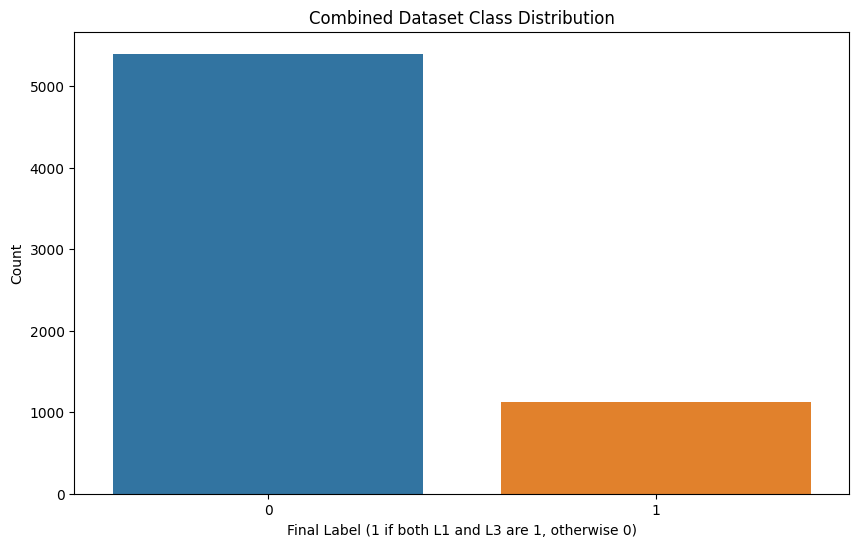

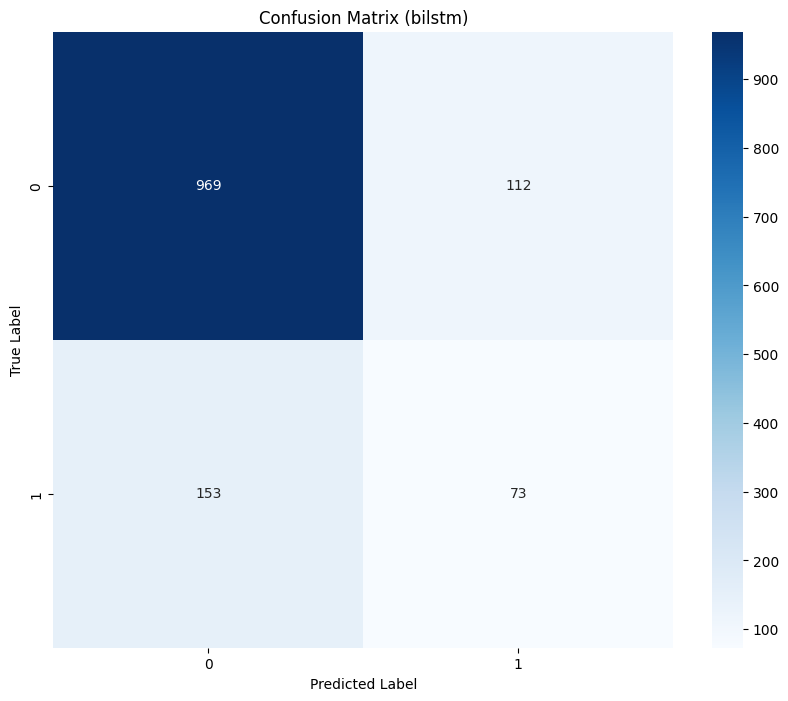

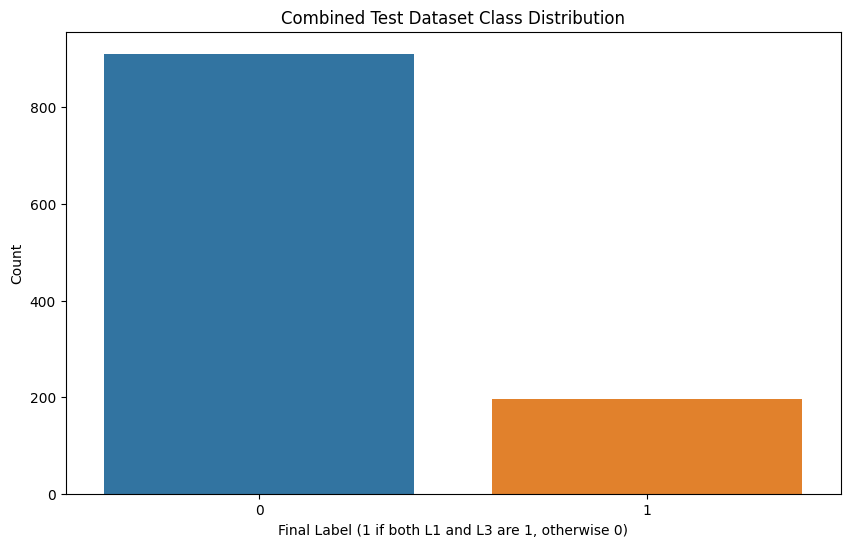

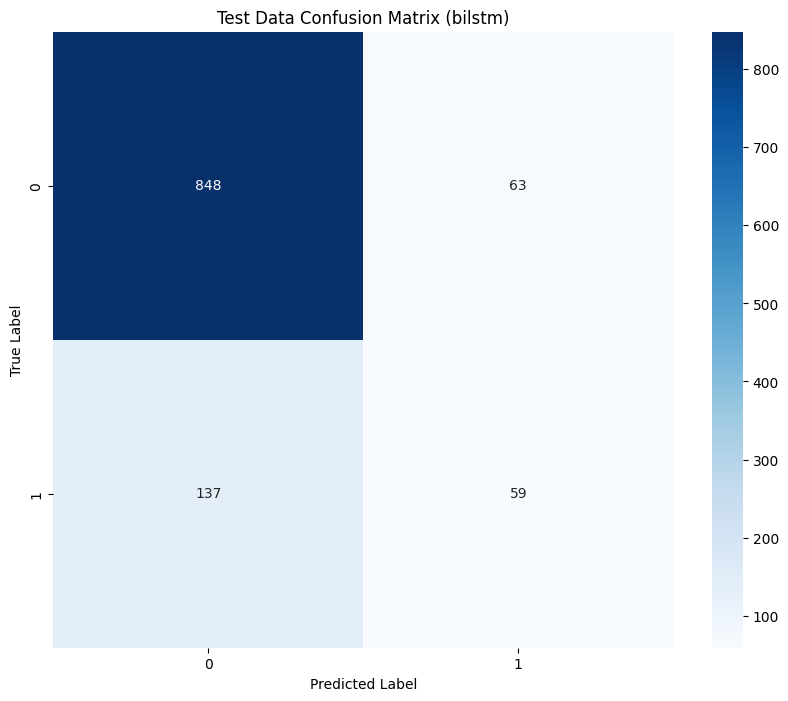

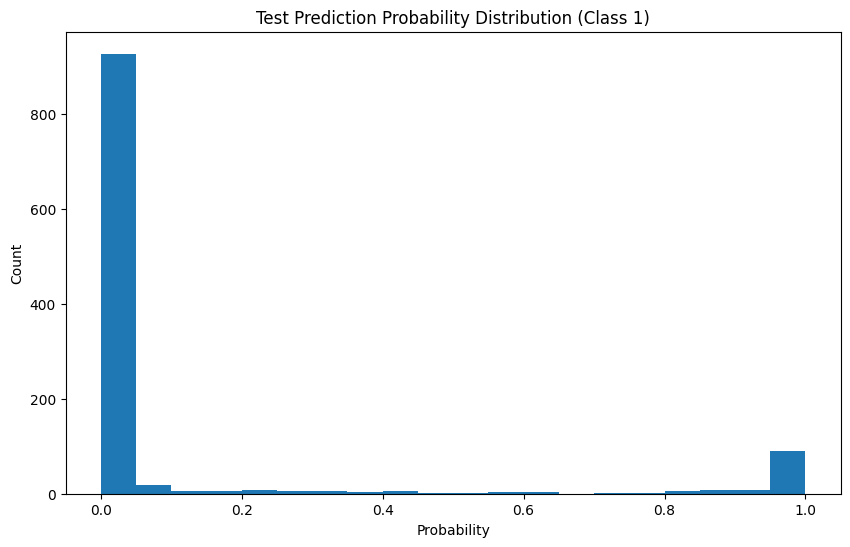

In [13]:
def main():
    """
    Main function to run the entire pipeline:
    1. Train the BiLSTM model on combined L1 and L3 datasets
    2. Evaluate the model on test data
    3. Save the model
    4. Run inference on sample texts
    """
    print("="*80)
    print("Starting BiLSTM-based Classification Pipeline")
    print("="*80)
    
    # Set paths to your data files
    l1_train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l1.csv"  # Path to L1 training data
    l3_train_file = "/kaggle/input/capstone/uli_dataset-main/training/train_en_l3.csv"  # Path to L3 training data
    l1_test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l1.csv"    # Path to L1 test data
    l3_test_file = "/kaggle/input/capstone/uli_dataset-main/testing/test_en_l3.csv"    # Path to L3 test data
    model_save_path = "trained_combined_classifier_bilstm.joblib"
    
    # Step 1: Train the model
    print("\nStep 1: Training the BiLSTM model on combined datasets...")
    model, f1_score, report = train_combined_classifier_bilstm(
        l1_train_file, 
        l3_train_file
    )
    
    if model is None:
        print("Error: Model training failed. Exiting.")
        return
    
    print(f"\nTraining complete with Macro F1 Score: {f1_score:.4f}")
    
    # Step 2: Evaluate on test data
    print("\nStep 2: Evaluating the model on combined test datasets...")
    test_f1, test_report, test_results = evaluate_on_combined_test_data_bilstm(
        model,
        l1_test_file,
        l3_test_file,
        output_file='combined_test_predictions_bilstm.csv'
    )
    
    if test_f1 is None:
        print("Error: Model evaluation failed.")
    else:
        print(f"\nTest evaluation complete with Macro F1 Score: {test_f1:.4f}")
    
    # Step 3: Save the model
    print("\nStep 3: Saving the trained model...")
    save_success = save_model(model, model_path=model_save_path)
    
    if not save_success:
        print("Error: Failed to save the model.")
    
    # Step 4: Run inference on sample texts
    print("\nStep 4: Running inference on sample texts...")
    demo_inference(model_path=model_save_path)
    
    print("\nStep 5: Additional options (uncomment in the code to use):")
    print("- To predict on a new dataset: predict_on_new_data_bilstm(model, 'new_data.csv', 'predictions.csv')")
    print("- To load a saved model: loaded_model = joblib.load('trained_combined_classifier_bilstm.joblib')")
    
    print("\nAll steps completed!")
    
    return model  # Return the model for further use if needed


# Sample usage of additional functions (for reference):
"""
# To predict on a new dataset
new_data_file = "new_data.csv"  # Path to new data
predictions_file = "predictions_bilstm.csv"  # Path to save predictions
predict_on_new_data_bilstm(model, new_data_file, predictions_file)

# To load a saved model and make predictions
loaded_model = joblib.load("trained_combined_classifier_bilstm.joblib")
sample_texts = [
    "This restaurant would not serve me because of my race.",
    "I really enjoyed the movie, it was entertaining from start to finish."
]
predictions = load_model_and_predict("trained_combined_classifier_bilstm.joblib", sample_texts)
"""

# Execute main function when script is run directly
if __name__ == "__main__":
    main()